# Transferencia de Aprendizaje para la Clasificación de Flores con EfficientNet

In [1]:
# Importacion de librerias
import os
import time
import tensorflow as tf
import numpy as np
import tf2onnx
from matplotlib import pyplot as plt  
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

2025-11-28 09:11:49.895835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 09:11:49.897412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 09:11:49.901105: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 09:11:49.909273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764339109.922050 1974872 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764339109.92

In [2]:
# Fijamos las semillas para reproductibilidad
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Descargando el dataset

El dataset que usaremos es uno de flores el cual contiene 104 clases. Lo puedes decargar en este enlace https://www.kaggle.com/competitions/flower-classification-with-tpus. Asegurate de modificar la variable `data_dir` a tu directorio en donde descargarás el dataset.

In [3]:
BATCH_SIZE=32
IMAGE_SIZE = [224, 224]  
AUTO = tf.data.AUTOTUNE

def decode_image(image_data):
    """Convierte bytes a imagen y aplica preprocesamiento de ResNet"""
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image

def read_labeled_tfrecord(example):
    """Parsea un tfrecord con imagen + etiqueta"""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),  # la imagen como bytes
        "class": tf.io.FixedLenFeature([], tf.int64),   # la etiqueta
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def load_dataset_from_folder(folder, train=False):
    filenames = tf.io.gfile.glob(os.path.join(folder, "*.tfrec"))

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)  
    dataset = dataset.cache()
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    
    if train:
        dataset = dataset.shuffle(buffer_size=1000, seed=SEED)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


In [4]:
# Rutas
dataset_dir = "DATASETS/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_folder = f"{dataset_dir}/train"
val_folder   = f"{dataset_dir}/val"
test_folder  = f"{dataset_dir}/test"

# Cargar datasets
train_ds = load_dataset_from_folder(train_folder, train=True)
val_ds   = load_dataset_from_folder(val_folder)
test_ds  = load_dataset_from_folder(test_folder)

2025-11-28 09:11:51.969393: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Verificamos que tanto las dimensiones como las etiquetas sean correctas.
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

2025-11-28 09:11:52.118481: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


Images shape: (32, 224, 224, 3)
Labels shape: (32,)


2025-11-28 09:11:52.283916: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
# Aumentamos los datos de entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)


## Modelo

Usaremos efficientnet como extractor de características, y agregaremos una capa densa de clasificación al final con 104 neuronas (el número de clases).

In [ ]:
NUM_CLASSES = 104  

# Cargar ResNet-50 preentrenada en ImageNet
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,      # quitamos la capa de clasificación original
    weights='imagenet',     # pesos preentrenados
    input_shape=(224, 224, 3)
)

# Congelar la base si quieres transfer learning
base_model.trainable = False

# Crear modelo completo
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)), 
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/home/lcc_rn_08/.conda/envs/Medium_2/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 104)            │       133,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,182,795 (15.96 MB)

 Trainable params: 133,224 (520.41 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Entrenamiento del Modelo


In [8]:
start_time = time.time()

EPOCHS = 1

from collections import Counter

# Función para extraer todas las etiquetas de un dataset
def get_labels(dataset):
    labels = []
    for _, y in dataset:
        labels.extend(y.numpy())
    return np.array(labels)

# Extraemos las etiquetas de entrenamiento
train_labels = get_labels(train_ds)

classes = np.arange(NUM_CLASSES)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)
class_weight_dict = dict(zip(classes, class_weights))

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict, 
    callbacks=[early_stop],
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

2025-11-28 09:12:05.333646: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    399/Unknown 154s 372ms/step - accuracy: 0.0503 - loss: 4.6529

2025-11-28 09:14:39.180264: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/lcc_rn_08/.conda/envs/Medium_2/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


399/399 ━━━━━━━━━━━━━━━━━━━━ 195s 476ms/step - accuracy: 0.1120 - loss: 4.4034 - val_accuracy: 0.3273 - val_loss: 3.7534
Tiempo total de entrenamiento: 207.30 segundos


Veamos las gráficas de entrenamiento y validación.

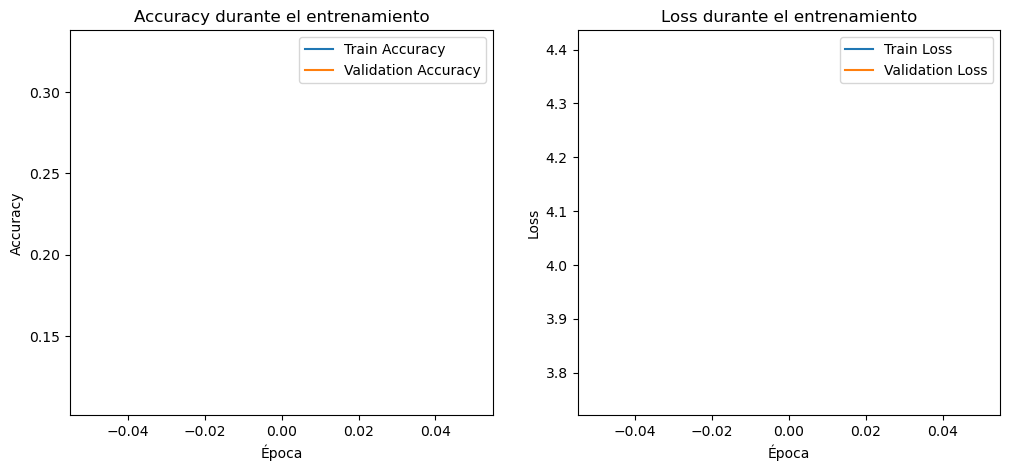

In [9]:
# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.savefig("accuracy_loss.png", dpi=300)  # nombre y resolución
plt.show()

Ahora hacemos finetuning ya que se estanco el entrenamiento.

In [ ]:
# --- FINE-TUNING ---
# Descongelamos la base
base_model.trainable = True

# Descongelamos las ultimas 20 capas
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilamos con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento con fine-tuning
fine_tune_epochs = 10  # puedes ajustar según la convergencia
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,  # empieza desde donde quedó el entrenamiento previo
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 2/11


     20/Unknown 15s 398ms/step - accuracy: 0.1381 - loss: 4.7484

KeyboardInterrupt: 

In [ ]:
# Accuracy y Loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento con finetuning')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento con finetuning')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Guardar la figura en un archivo
plt.savefig("finetuning_accuracy_loss.png", dpi=300)  # nombre y resolución

plt.show()


Se muestran estables y las dos convergen en la misma dirección, con lo cual el entrenamiento del modelo fue exitoso. Procedemos a almacenar el modelo

In [ ]:

dummy = tf.random.uniform((1, 224, 224, 3))
_ = model(dummy)   # fuerza a que el modelo defina sus outputs

inputs = tf.keras.Input(shape=(224, 224, 3))
outputs = model(inputs)
model = tf.keras.Model(inputs, outputs)  # usa los mismos pesos


spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13  # puedes subirlo a 17 si lo necesitas
)

with open("modelo.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

I0000 00:00:1764336604.753596 1950548 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1764336604.754173 1950548 single_machine.cc:361] Starting new session
I0000 00:00:1764336605.973071 1950548 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1764336605.973282 1950548 single_machine.cc:361] Starting new session


## Resultados 

Probamos en nuestro conjunto de validación diferentes métricas para ver la calidad de nuestro modelo.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Valores verdaderos.
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Valores predichos por el modelo.
probs = model.predict(val_ds)
y_pred = np.argmax(probs, axis = 1)

116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step


In [ ]:
# Metricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy (Global): {acc:.4f}")
print(f"Precision (Weighted): {prec:.4f}")
print(f"Recall (Weighted):    {rec:.4f}")
print(f"F1-Score (Weighted):  {f1:.4f}")

Accuracy (Global): 0.8386
Precision (Weighted): 0.8550
Recall (Weighted):    0.8386
F1-Score (Weighted):  0.8403


Vemos que obtenemos resultados bastante buenos, veamos como es por cada clase con la matriz de confusion y con metricas por clase.

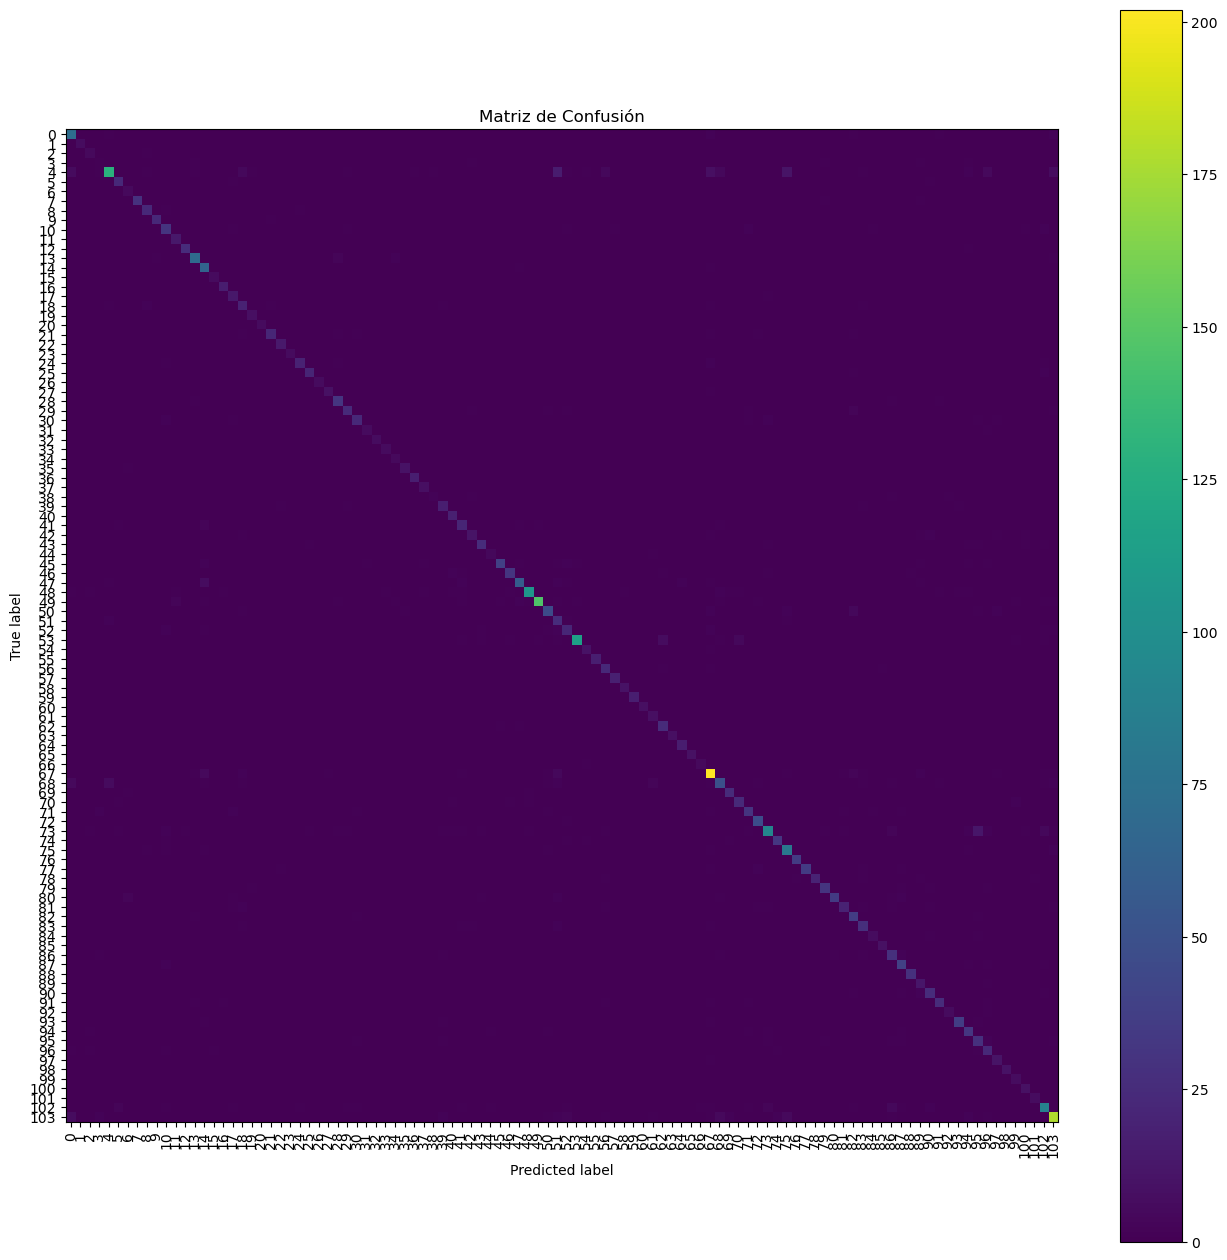

In [ ]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(16, 16))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(
    include_values=False,     
    cmap='viridis',           
    ax=ax,                    
    xticks_rotation='vertical'
)

plt.title('Matriz de Confusión')
plt.show()

Se muestra la diagonal con un color diferente, indicandonos que el modelo si identifíca bien todas las clases. Veamos el reporte de clasificación por cada clase

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        79
           1       1.00      1.00      1.00         7
           2       0.56      0.83      0.67         6
           3       0.14      0.17      0.15         6
           4       0.92      0.63      0.75       205
           5       0.79      0.92      0.85        25
           6       0.50      1.00      0.67         5
           7       1.00      0.94      0.97        31
           8       0.82      0.92      0.87        25
           9       0.96      0.96      0.96        24
          10       0.68      0.75      0.71        40
          11       0.76      1.00      0.87        13
          12       0.96      0.96      0.96        27
          13       0.92      0.91      0.92        77
          14       0.74      0.97      0.84        66
          15       0.86      1.00      0.92         6
          16       0.89      1.00      0.94        16
          17       0.62    

In [ ]:
def read_unlabeled_tfrecord(example):
    """Parsea un tfrecord solo con imagen, sin etiqueta"""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),  # la imagen como bytes
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    return image  # sin etiqueta

def load_test_dataset(folder):
    filenames = tf.io.gfile.glob(os.path.join(folder, "*.tfrec"))
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.batch(1)
    dataset = dataset.prefetch(AUTO)
    return dataset

test_ds = load_test_dataset(test_folder)


Vemos que el reporte coincide con la matriz de confusion.

In [ ]:
for i, img_batch in enumerate(test_ds.take(20)):
    # img_batch tiene forma (batch_size, 224, 224, 3)
    # Aquí batch_size=1
    img_input = img_batch  # ya es un batch de 1 imagen

    # Predicción
    probs = model.predict(img_input)
    pred_class = np.argmax(probs[0])
    confidence = probs[0][pred_class]

    # Mostrar
    plt.figure()
    plt.imshow(img_input[0].numpy().astype(np.uint8))
    plt.axis('off')
    plt.title(f"Predicción: {pred_class} (Confianza: {confidence:.2f})")
    plt.show()





NameError: name 'test_ds' is not defined